# ASPEN Paper - Figure 4 and its supplement

In [62]:
# Loading required libraries
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(gridExtra)
    library(ggpubr)
    library(scales)
    library(foreach)
    library(reshape2)
    library(locfit)
    library(scran)
    library(zoo)
    library(MatchIt)
    library(coin)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(jcolors)
    library(ComplexHeatmap)
    library(ggvenn)
    library(tibble)
})

In [39]:
#Functions for plotting

plot_scatter <- function(param_reestim){

  ggplot(param_reestim, aes(log(tot_gene_mean), log(bb_theta))) +
    geom_point(size = 0.7, colour = "darkgrey") +
    geom_line(aes(log(tot_gene_mean), log(theta_common)), color = "black", linewidth = 1, group = 1) +
    theme_classic(base_size = 20) +
    theme(legend.position = "none", legend.title = element_blank()) +
    annotate("text", x=2, y=3.5, label= paste("N genes:", nrow(param_reestim)), size = 6) 
}

# True positive rate calculation
calc_tpr <- function(pvals, sequence){
  
    tpr <- vector()
    tp <- vector()
    fn <- vector()
    
    for (i in seq_along(sequence)){
      prediction <- ifelse(pvals <= sequence[i], 1, 0)
      df <- as.data.frame(prediction)
      t <- df %>% dplyr::group_by(prediction) %>% tally()
      t <- as.data.frame(t)
      tp[i] <- ifelse(length(t[t$prediction == 1, "n"]) != 0, 
                      t[t$prediction == 1, "n"], 0) #true positives
      fn[i] <- ifelse(length(t[t$prediction == 0, "n"]) != 0,
                      t[t$prediction == 0, "n"], 0) #false negative
    }
    
   
    for (i in seq_along(sequence)){
      tpr[i] <- tp[i]/(tp[i]+fn[i])
    }
    
    list(tp = tp, fn = fn, tpr = tpr)
  
}

# Barplot of true positive rates
barplot_tpr <- function(df){
  ggplot(df, aes(x = as.factor(FDR), y = tpr, fill = scenario, color = scenario)) +
    geom_col(position = "dodge", width = 0.7) +
    theme_classic(base_size = 20) +
    theme(panel.grid.minor = element_blank()) +
    theme(legend.title = element_blank(), legend.position = "bottom", legend.box.spacing = unit(0, "pt")) +
    labs(y = "TPR", x = "FDR cut-off") +
    scale_fill_manual(values = c("black", "grey")) +
    scale_color_manual(values = c("black", "grey"))
}

#Tile plot for changes in allelic ratio
plot_tiles_ar <- function(df){
    ggplot(df, aes(x = cell_type, y = genes, fill = value)) +
        geom_tile() +
        theme_classic(base_size = 20) +
        scale_fill_gradient2(low = cont_pal[1], mid = cont_pal[6], high = cont_pal[11], 
                             midpoint = 0.5, name = "Allelic Ratio", limits=c(0,1)) +
        theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt"),
              axis.title.y = element_blank(), axis.title.x = element_blank(), 
              axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5),
              plot.subtitle = element_text(hjust = 1))
}

#Tile plot for changes in allelic variation
plot_tiles_var <- function(df){
    ggplot(df, aes(x = cell_type, y = genes, fill = value)) +
        geom_tile() +
        theme_classic(base_size = 20) +
        scale_fill_viridis_c(option = "mako", direction = -1 , limits = c(0,0.2)) +
        theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt"),
              axis.title.y = element_blank(), axis.title.x = element_blank(),
              axis.text.x = element_text(angle = 90, hjust = 0.5, vjust = 0.5, size = 20),
              plot.subtitle = element_text(hjust = 1))
}

### Figure 4B

Plot of dispersion estimates over mean gene expression, indicating genes with allelic variation deviating from the expected levels for genes with similar expression (based on ASPEN-var test results for Bl6Cast hybrids).

In [102]:
#Loading test results
celltypes <- list("Cortical neurons", "IPCs", "RGCs")
res = "./aspen_output/brain_organoids/Bl6Cast/"
bb_mean_res_organoids <- lapply(celltypes, function(q) read.xlsx(paste0(res, "Bl6_Cast_organoids_ASPENmean.xlsx"), 
                                                                 sheet = paste0(q, "_Cast_B6"), rowNames = T))
bb_var_res_organoids <- lapply(celltypes, function(q) read.xlsx(paste0(res, "Bl6_Cast_organoids_ASPENvar.xlsx"), 
                                                                sheet = paste0(q, "_Cast_B6"), rowNames = T))


In [103]:
mapply(function(p, q) table(rownames(p) == rownames(q)),
       bb_mean_res_organoids, bb_var_res_organoids)

TRUE TRUE TRUE 
 973  857 1078

In [105]:
#combining test results into one table
organoids_res <- bb_mean_res_organoids
organoids_res <- mapply(function(p, q) {p$pval_var <- q$pval_disp[match(rownames(p), rownames(q))];
                                      return(p)}, organoids_res, bb_var_res_organoids, SIMPLIFY = FALSE)
lapply(organoids_res, dim) 

[[1]]
[1] 973  32

[[2]]
[1] 857  32

[[3]]
[1] 1078   32

In [106]:
#recalculating FDR
organoids_res <- lapply(organoids_res, function(q) {q$fdr_mean <- p.adjust(q$pval_mean, method = "fdr");
                                                   q$fdr_var <-  p.adjust(q$pval_var, method = "fdr");
                                                    q$vardeviat <- ifelse(q$fdr_var < 0.05, 1, 0);
                                                    q$gene <- rownames(q);
                                                              return(q)})

In [107]:
p <- mapply(function(p, q) plot_scatter(p) +
    geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 0.5) +
    geom_point(data = subset(p, vardeviat == 1), colour = "#A73030FF", size = 0.7) +
   annotate("text", x=1, y=4.5, label= paste0("N sign var genes:", table(p$vardeviat)[2]), size = 6) +
            labs(subtitle = q),
           organoids_res, celltypes, SIMPLIFY = F)

TableGrob (1 x 3) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]

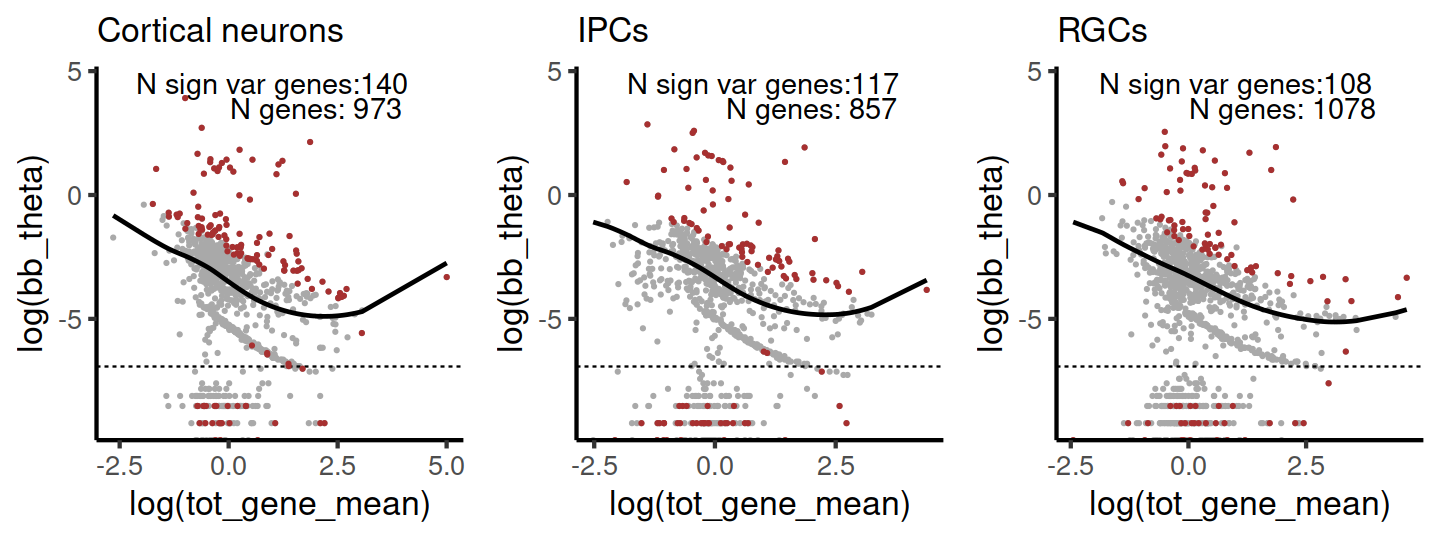

In [108]:
options(repr.plot.width = 12, repr.plot.height = 4.5)
p <- do.call(grid.arrange, c(p, ncol = 3))
p

### Figure 4C

GO term enrichment analysis

In [38]:
#splitting each time point by dispersion group
organoids_res <- lapply(organoids_res, function(q) {q$disp_group <- ifelse(q$fdr_var < 0.05 
                                                                           & q$bb_theta < q$theta_common, 
                                                                           "lowdisp", NA);
                                                                return(q)})

In [48]:
organoids_comb <- do.call(rbind, organoids_res)
#excluding ribosomal genes 
genes.use <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]", 
                                                         rownames(organoids_comb), value=TRUE, invert=TRUE)
organoids_comb <- organoids_comb[genes.use,]                    
organoids_comb$disp_group <- ifelse(organoids_comb$fdr_var < 0.05 & organoids_comb$bb_theta < organoids_comb$theta_common, "lowdisp", NA)
organoids_comb$disp_group <- ifelse(organoids_comb$fdr_var < 0.05 & organoids_comb$bb_theta > organoids_comb$theta_common, "highdisp", organoids_comb$disp_group)
table(organoids_comb$disp_group)


highdisp  lowdisp 
     235       85 

In [49]:
#defining background and converting gene names to ENTREZ IDs
genes <- unique(organoids_comb$gene)
bkg_genes <- bitr(genes, fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)
#converting gene names to ENTREZ IDs
high_disp_genes <- bitr(unique(organoids_comb$gene[organoids_comb$disp_group == "highdisp"]), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)
low_disp_genes <- bitr(unique(organoids_comb$gene[organoids_comb$disp_group == "lowdisp" & organoids_comb$tot_gene_mean < 100]), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db):
“0.87% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique(organoids_comb$gene[organoids_comb$disp_group == :
“0.67% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique(organoids_comb$gene[organoids_comb$disp_group == :
“2.38% of input gene IDs are fail to map...”


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


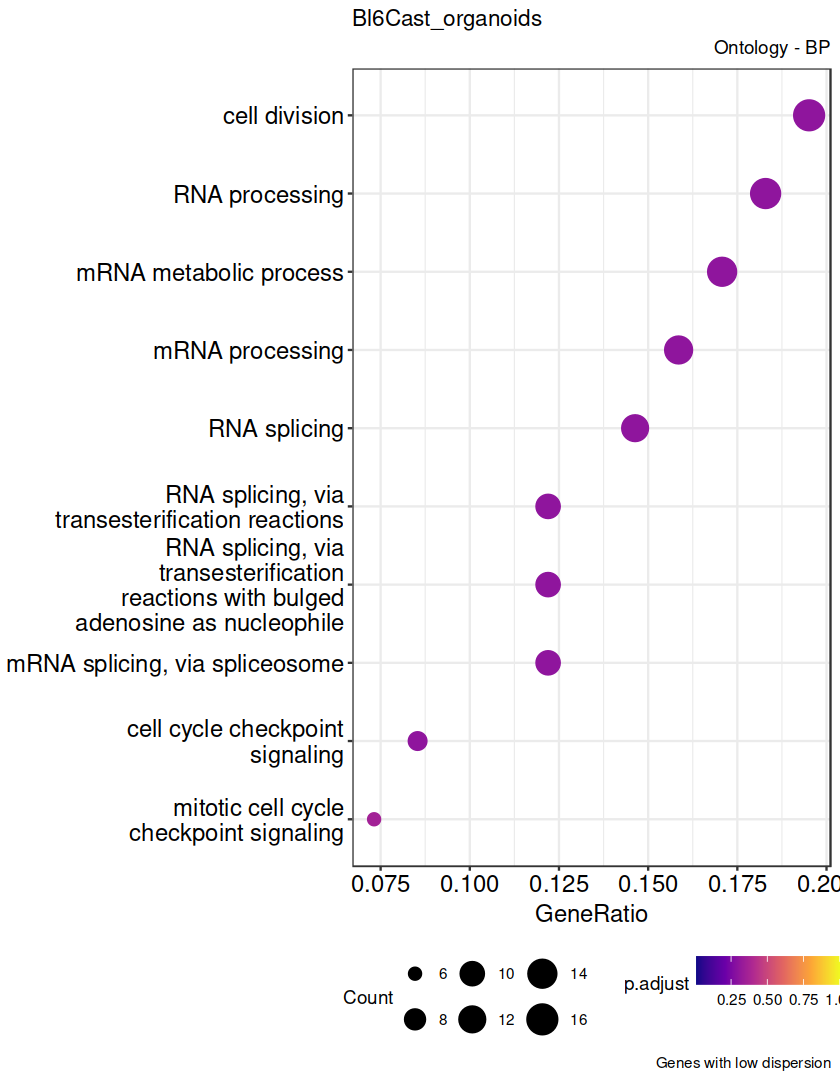

In [50]:
options(repr.plot.width = 7, repr.plot.height = 9)
ego_sets_lowdisp <- enrichGO(gene = low_disp_genes$ENTREZID,
                             universe = bkg_genes$ENTREZID,
                             OrgDb = org.Mm.eg.db,
                             ont = "BP", #"MF",
                             pAdjustMethod = "BH",
                             pvalueCutoff  = 0.5,
                             qvalueCutoff  = 0.5,
                             readable = TRUE)

ego_res <- dotplot(ego_sets_lowdisp, showCategory = 10, font.size=14) +
                   scale_colour_viridis_c(limits=c(1e-02, 1), option = "plasma") +
                   theme(legend.position = "bottom", plot.subtitle = element_text(hjust = 1)) +
                   labs(subtitle = "Ontology - BP", title = "Bl6Cast_organoids", caption = "Genes with low dispersion")
ego_res

In [51]:
ego_sets_lowdisp@result[1:10,]

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006397,GO:0006397,mRNA processing,13/82,72/1216,0.0006274698,0.3031012,0.3024054,Bcas2/Aplp1/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Alyref/Paxbp1/Celf4/Malat1/Sf3b1/Thoc7,13
GO:0006396,GO:0006396,RNA processing,15/82,92/1216,0.0007272871,0.3031012,0.3024054,Bcas2/Aplp1/Snrnp70/Hnrnpa1/Eif6/Khdrbs1/Srsf9/Luc7l2/Alyref/Paxbp1/Celf4/Malat1/Sf3b1/Ddx18/Thoc7,15
GO:0008380,GO:0008380,RNA splicing,12/82,66/1216,0.0009738290,0.3031012,0.3024054,Bcas2/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Alyref/Paxbp1/Celf4/Malat1/Sf3b1/Thoc7,12
GO:0016071,GO:0016071,mRNA metabolic process,14/82,85/1216,0.0010095295,0.3031012,0.3024054,Csde1/Bcas2/Aplp1/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Alyref/Paxbp1/Celf4/Malat1/Sf3b1/Thoc7,14
GO:0000075,GO:0000075,cell cycle checkpoint signaling,7/82,28/1216,0.0018244301,0.3031012,0.3024054,Spc25/Aurka/Cdc20/Cdca8/Clspn/Spc24/Tipin,7
GO:0000375,GO:0000375,"RNA splicing, via transesterification reactions",10/82,53/1216,0.0019960366,0.3031012,0.3024054,Bcas2/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Paxbp1/Celf4/Malat1/Sf3b1,10
GO:0000377,GO:0000377,"RNA splicing, via transesterification reactions with bulged adenosine as nucleophile",10/82,53/1216,0.0019960366,0.3031012,0.3024054,Bcas2/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Paxbp1/Celf4/Malat1/Sf3b1,10
GO:0000398,GO:0000398,"mRNA splicing, via spliceosome",10/82,53/1216,0.0019960366,0.3031012,0.3024054,Bcas2/Snrnp70/Hnrnpa1/Khdrbs1/Srsf9/Luc7l2/Paxbp1/Celf4/Malat1/Sf3b1,10
GO:0051301,GO:0051301,cell division,16/82,112/1216,0.0021245411,0.3031012,0.3024054,Nudc/Cdk4/Bod1/Spc25/Nusap1/Aurka/Cdc20/Cdca8/Spc24/Tipin/Dync1h1/Racgap1/Ccna2/Rcc2/Cdca3/Lig1,16


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


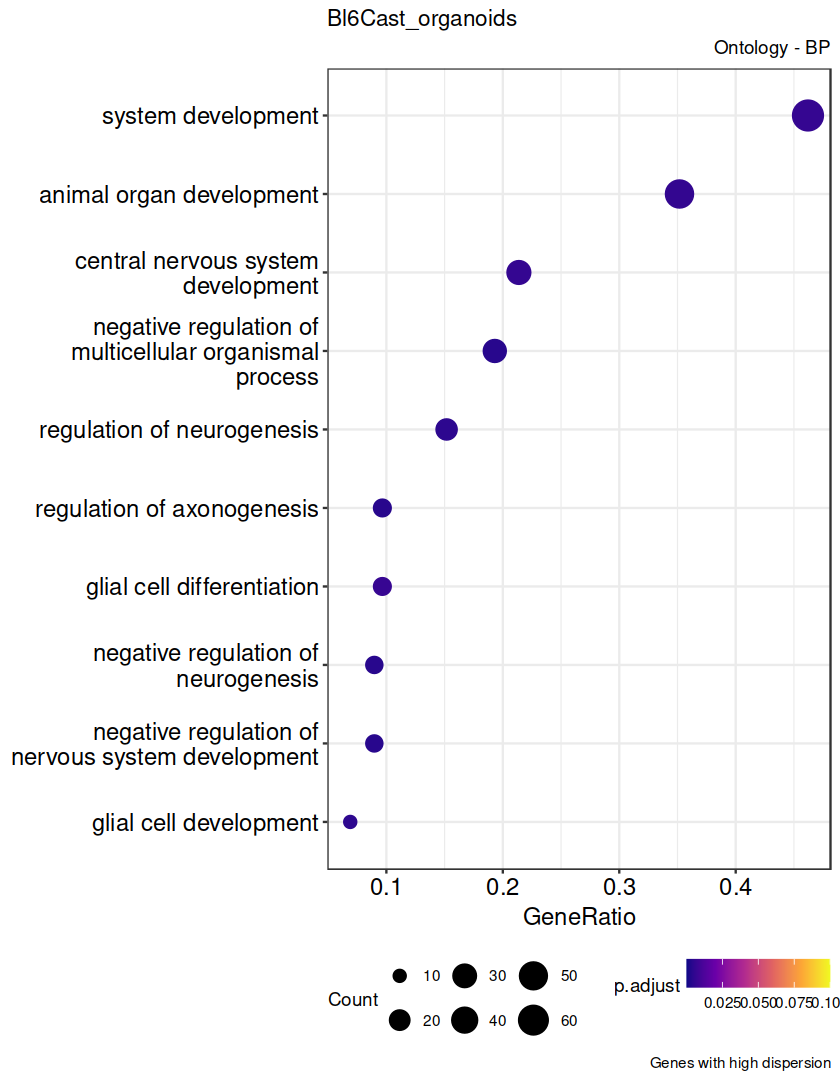

In [52]:
options(repr.plot.width = 7, repr.plot.height = 9)
ego_sets_highdisp <- enrichGO(gene = high_disp_genes$ENTREZID,
                             universe = bkg_genes$ENTREZID,
                             OrgDb = org.Mm.eg.db,
                             ont = "BP", #"MF",
                             pAdjustMethod = "BH",
                             pvalueCutoff  = 0.1,
                            qvalueCutoff  = 0.1,
                            readable = TRUE)

ego_res <- dotplot(ego_sets_highdisp, showCategory = 10, font.size=14) +
                   scale_colour_viridis_c(limits=c(1e-04, 1e-01), option = "plasma") +
                   theme(legend.position = "bottom", plot.subtitle = element_text(hjust = 1)) +
                   labs(subtitle = "Ontology - BP", title = "Bl6Cast_organoids", caption = "Genes with high dispersion")
ego_res

In [53]:
ego_sets_highdisp@result[1:10,]

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050770,GO:0050770,regulation of axonogenesis,14/145,33/1216,7.037315e-06,0.003700590,0.002949664,Map2/Vim/Pak3/Dcx/Plxna4/Apoe/Ntrk3/Mt3/Nrp1/Nefm/Tiam2/Wnt5a/Map1b/Sema5a,14
GO:0050768,GO:0050768,negative regulation of neurogenesis,13/145,29/1216,7.329036e-06,0.003700590,0.002949664,Map2/Btg2/Ptn/Ntrk3/Mt3/Nrp1/Id4/Id2/Sox11/Syt4/Wnt5a/Sema5a/Id1,13
GO:0051961,GO:0051961,negative regulation of nervous system development,13/145,29/1216,7.329036e-06,0.003700590,0.002949664,Map2/Btg2/Ptn/Ntrk3/Mt3/Nrp1/Id4/Id2/Sox11/Syt4/Wnt5a/Sema5a/Id1,13
GO:0051241,GO:0051241,negative regulation of multicellular organismal process,28/145,104/1216,8.556277e-06,0.003700590,0.002949664,Map2/Btg2/Cst3/Zfas1/Nfib/Sri/Ptn/Apoe/Ntrk3/Mt3/Nrp1/Arid4b/Id4/Id2/Sox11/Angpt1/App/Syt4/Rian/Prdx4/Hmgb1/Wnt5a/Sema5a/Igfbp5/Atp1a2/Id1/Rgcc/Sox9,28
GO:0021782,GO:0021782,glial cell development,10/145,19/1216,1.545726e-05,0.004784635,0.003813734,Vim/Gpm6b/Ntrk3/Mt3/Id4/Id2/Sox11/App/Sox4/Olig1,10
GO:0050767,GO:0050767,regulation of neurogenesis,22/145,74/1216,1.659411e-05,0.004784635,0.003813734,Map2/Btg2/Vim/Pak3/Dcx/Plxna4/Ptn/Apoe/Ntrk3/Mt3/Nrp1/Fzd3/Id4/Id2/Sox11/Tiam2/Syt4/Hes6/Wnt5a/Map1b/Sema5a/Id1,22
GO:0048513,GO:0048513,animal organ development,51/145,258/1216,2.383001e-05,0.005889416,0.004694332,Dner/Dbi/Btg2/Vim/Zfas1/Nsdhl/Maged1/Xist/Atrx/Dcx/Gpm6b/Bhlhe22/Nfib/Epha5/Plxna4/Ptn/Ube3a/Ntrk3/Nrp1/Fzd3/Nedd4/Selenom/Arid4b/Tubb2a/Id4/Id2/Sox11/Meg3/Angpt1/App/Rian/Prdx4/Neurog2/Hmgb1/Fabp7/Sorbs2/Aprt/Wnt5a/Ppib/Sox4/Fos/Sema5a/Igfbp5/Atp1a2/Cenpf/Id1/Hopx/Rgcc/Sox9/Emp2/Plaat3,51
GO:0007417,GO:0007417,central nervous system development,31/145,128/1216,2.838956e-05,0.006139243,0.004893464,Map2/Dbi/Btg2/Vim/Atrx/Dcx/Gpm6b/Bhlhe22/Nfib/Epha5/Plxna4/Ptn/Ntrk3/Mt3/Nrp1/Fzd3/Tubb2a/Id4/Id2/Sox11/App/Neurog2/Fabp7/Wnt5a/Sox4/Sema5a/Ecrg4/Atp1a2/Cenpf/Sox9/Olig1,31
GO:0048731,GO:0048731,system development,67/145,378/1216,3.310422e-05,0.006363368,0.005072109,Map2/Dner/Dbi/Btg2/Vim/Nsdhl/Maged1/Atrx/Pak3/Dcx/Gpm6b/Bhlhe22/Nfib/Gabra2/Epha5/Srrm4/Plxna4/Ptn/Snca/Chl1/Apoe/Ube3a/Ntrk3/Inpp5f/Mt3/Nrp1/Fzd3/Stmn4/Nefm/Pcdh17/Nedd4/Arid4b/Tubb2a/Id4/Id2/Sox11/Meg3/Angpt1/App/Pcp4/Tiam2/Syt4/Smarca2/Hes6/Prdx4/Neurog2/Hmgb1/Fabp7/Sorbs2/Ier2/Wnt5a/Ppib/Sox4/Map1b/Fos/Sema5a/Ecrg4/Igfbp5/Atp1a2/Cenpf/Id1/Hopx/Rgcc/Sox9/Emp2/Olig1/Plaat3,67


### Data simulated to benchmark dynamic ASE distribution changes: ASPEN dyn-mean and ASPEN dyn-var

The plots below describe the simulation strategy. We took the total counts matrix, simulated with zinbwave (Risso et al., 2018), and performed PCA analyses. PC1 coordinates were used as pseudotime trajectory vector (rescaled to [0,1] interval). We divided this vector into three equal-sized bins to mimic the early, middle and late stages of differentiation. Then, we simulated the allelic counts by either changing the mean allelic ratio or allelic dispersion parameters.   

### Figure 4E

In [2]:
#Loading simualated total counts
simul_data <- "./data/simulated/"
sim_tot <- readRDS(paste0(simul_data, "sim_tot_hvg2000_sce.rds"))
metadata <- as.data.frame(colData(sim_tot))
metadata$group <- cut(metadata$PC1_rescaled, breaks=c(quantile(metadata$PC1_rescaled, probs = seq(0, 1, by = 1/3))))

metadata$group[is.na(metadata$group)] <- levels(metadata$group)[1]
head(metadata)

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.2,RNA_snn_res.0.3,RNA_snn_res.0.5,seurat_clusters,PC1_orig,PC2_orig,UMAP1_orig,UMAP2_orig,PC1_rescaled,PT_group,group
,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
cell1,SeuratProject,1323,540,0,0,1,1,7.569703,-1.2086042,-0.08717767,1.8013076,0.7735326,"(0.731,1]","(0.731,1]"
cell2,SeuratProject,2225,625,2,2,3,3,-6.295900,-0.7572888,-2.49822416,-1.9112121,0.4381444,"(0,0.495]","(0,0.495]"
cell3,SeuratProject,2959,628,0,0,1,1,9.937639,-3.1794338,0.48713405,2.9615006,0.8308095,"(0.731,1]","(0.731,1]"
cell4,SeuratProject,1045,457,2,1,2,2,-4.328174,-2.0144983,-4.32467975,-0.7384076,0.4857407,"(0,0.495]","(0,0.495]"
cell5,SeuratProject,1795,566,0,0,1,1,11.235686,-0.4487109,1.03983925,2.6953692,0.8622073,"(0.731,1]","(0.731,1]"
cell6,SeuratProject,645,271,1,1,2,2,-4.569697,2.9626579,0.92062632,-3.4762074,0.4798987,"(0,0.495]","(0,0.495]"


In [ ]:
UMAP embedding. Cells are coloured by the rescaled PC1 coordinates 

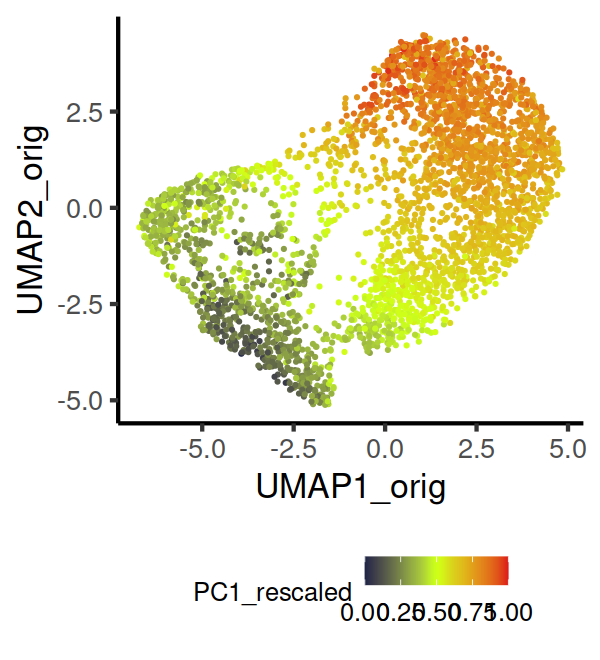

In [10]:
options(repr.plot.width = 5, repr.plot.height = 5.5)
plot_umap <- function(metadata){
    ggplot(metadata, aes(x=UMAP1_orig, y=UMAP2_orig, color = PC1_rescaled)) + 
    geom_point(size = 0.7) +
    theme_classic(base_size = 20) +
    theme(legend.position = "bottom", legend.text=element_text(size=15), 
          legend.title=element_text(size=15)) +
    scale_color_jcolors_contin(palette = "pal12")}
plot_umap(metadata)

### Figure 4F

UMAP embedding, cells are coloured by the three pseudotime groups.

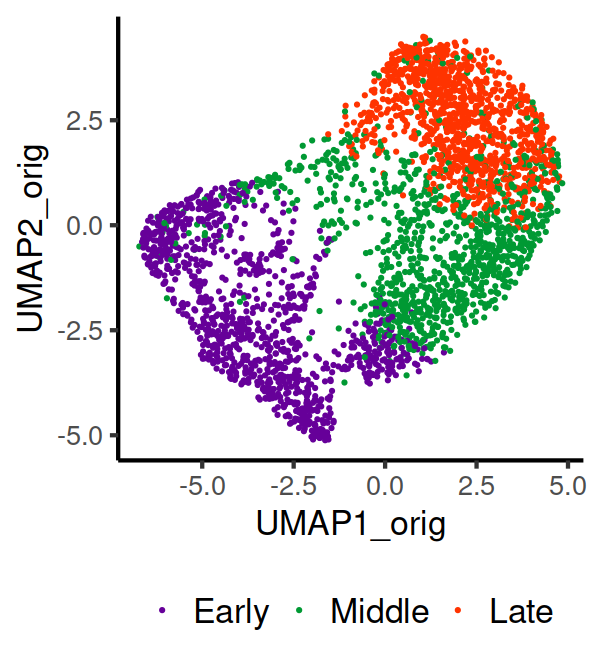

In [14]:
plot_umap <- function(metadata){
    ggplot(metadata, aes(x=UMAP1_orig, y=UMAP2_orig, color = group)) + 
    geom_point(size = 0.7) +
    theme_classic(base_size = 20) +
    theme(legend.position = "bottom", legend.text=element_text(size=20), 
          legend.title=element_blank()) +
    scale_color_manual(values = c("#660099", "#009933", "#FF3300"),
                      labels = c("Early", "Middle", "Late"))}

plot_umap(metadata) 

### Supplemental Figure 3A

To evaluate ASPEN's ability to detect changes in the allelic mean ratio and variance across pseudo(time), three simulation groups were created: 
- mimicking changes in the allelic ratio mean;
- mimicking changes in the allelic ratio variation;
- control group (no changes in the allelic ratio mean or variance).

Desnity plots to demonstrate scenarios 1, 2 and 3

In [21]:
plot_density <- function(a1_counts, tot_counts, gene, metadata){

      df <- as.data.frame(cbind(y = a1_counts[gene,], n = tot_counts[gene,]))
      df$pseudotime <- metadata$PC1_rescaled[match(rownames(df), rownames(metadata))]
      df$`Allelic ratio` <- df$y/df$n
      df$group <- metadata$group[match(rownames(df), rownames(metadata))]
      df <- df[order(df$pseudotime),]
      df$Index <- 1:nrow(df) 
    
      ggplot(df) +
        geom_density(aes(x = `Allelic ratio`, colour = group, fill = group), alpha = 0.55) +
        theme_classic(base_size = 15) +
        theme(panel.grid.minor = element_blank(), 
              axis.title.x = element_text(size = 15), 
              axis.title.y = element_text(size = 15), 
              axis.text.y = element_text(size = 15), 
              xis.text.x = element_text(size = 15)) +
        theme(plot.title = element_text(size = 18), 
              plot.subtitle = element_text(size = 14), 
              legend.title = element_blank(), 
              legend.position = "bottom", 
              legend.box.spacing = unit(0, "pt")) +
        scale_color_manual(values = c("#660099", "#009933", "#FF3300"),
                          labels = c("Early", "Middle", "Late")) +
        scale_fill_manual(values = c("#660099", "#009933", "#FF3300"),
                         labels = c("Early", "Middle", "Late"))

}

In [15]:
#loading simulated data
a1_counts_pseudot <- readRDS(paste0(simul_data, "a1_counts_pseudot_hvg2000.rds"))
tot_counts_pseudot <- readRDS(paste0(simul_data, "tot_counts_pseudot_hvg2000.rds"))

#adding rownames and column names - MUST match total counts
a1_counts_pseudot <- lapply(a1_counts_pseudot, function(q) {colnames(q) <- colnames(tot_counts_pseudot);
                                                            return(q)})
a1_counts_pseudot <- lapply(a1_counts_pseudot, function(q) {rownames(q) <- rownames(tot_counts_pseudot);
                                                            return(q)})

Warning message:
“Removed 32 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in plot_theme(plot):
“The `xis.text.x` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 32 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in plot_theme(plot):
“The `xis.text.x` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 32 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message in plot_theme(plot):
“The `xis.text.x` theme element is not defined in the element hierarchy.”


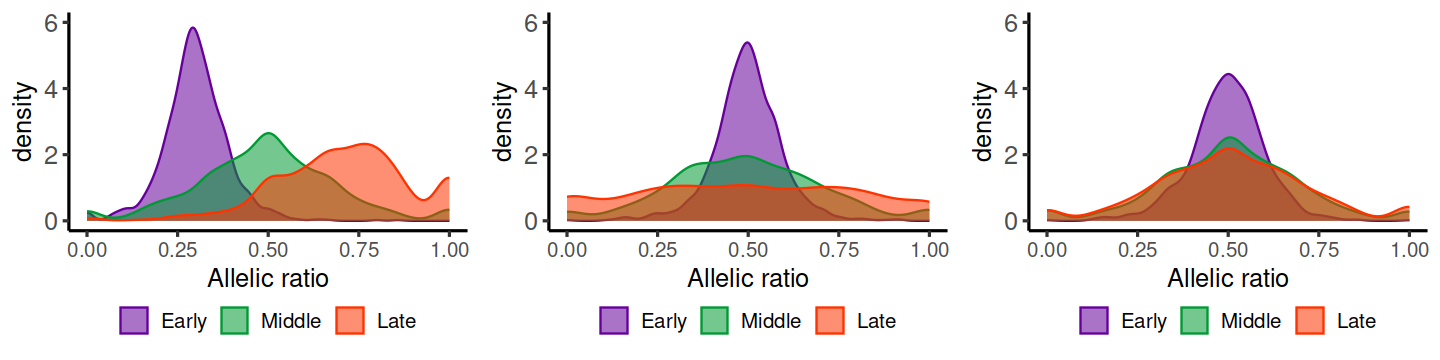

In [22]:
options(repr.plot.width = 12, repr.plot.height = 3)
simul_group <- list("Changes in Mean", "Changes in Variance", "Control")
gene = 2
pt_distr <- mapply(function(p, q) plot_density(p, tot_counts_pseudot, gene, metadata) + ylim(0,6), 
                 a1_counts_pseudot, simul_group, SIMPLIFY = F)

p <- do.call(grid.arrange, c(pt_distr, ncol = 3))

### Figure 4G

Evaluating True Positive Rates for ASPEN dyn-mean applied to the simulated data under the Scenario 1 (changes in the allelic ratio mean) vs. the Control group and for ASPEN dyn-var applied to the simulated data under the Scenario 2 (changes in the allelic dispersion) vs. the Control group.

In [23]:
#loading test results
simul_dir <- "./aspen_output/simulated/"
pseudot_change <- readRDS(paste0(simul_dir, "simul_pseudot_change_ASPENdyn.rds"))

In [26]:
#adding FDRs
pseudot_change <- lapply(pseudot_change, function(q) {q$fdr_mean <- ifelse(!is.na(q$pval_mean),
                                                                           p.adjust(q$pval_adj, 
                                                                                    method = "fdr"), NA);
                                                      q$fdr_var <- ifelse(!is.na(q$pval_var),
                                                                           p.adjust(q$pval_var, 
                                                                                    method = "fdr"), NA);
                                                      return(q)})

In [27]:
#Selecting genes that have more than 5 cells with at least 5 mapped reads
pseudot_change <- lapply(pseudot_change, function(q) {q$N <- as.numeric(q$N);
                                                      q$tot_gene_mean <- as.numeric(q$tot_gene_mean)
                                                      return(q)})
pseudot_change_sub <- lapply(pseudot_change, function(q) q[q$N >=5,])

#assigning genes into three groups by GE                             
pseudot_change_sub <- lapply(pseudot_change_sub, function(q) {q$ge_group <- cut(q$tot_gene_mean, breaks=c(quantile(q$tot_gene_mean, c(0, 0.4, 0.9, 1))));
                                                  return(q)})

pseudot_change_sub <- lapply(pseudot_change_sub, function(q) {levels(q$ge_group) <- c("log(TPM) < 3", "log(TPM) < 8", "log(TPM) > 8");
                                                return(q)})

pseudot_change_ge_group <- lapply(pseudot_change_sub, function(q) split(q, f = q$ge_group))

In [28]:
#Calculate TPR for each test at three fdr cut-offs
range <- c(1e-03, 5e-02, 1e-01)
#mean test result are evaluated using Bayesian shrinkage adjusted parameters
tpr_pseudot_mean <- lapply(pseudot_change_ge_group, function(p) 
                            lapply(p, function(q)
                              calc_tpr(na.omit(q$fdr_mean), range)))
tpr_pseudot_var <- lapply(pseudot_change_ge_group, function(p) 
                            lapply(p, function(q)
                              calc_tpr(na.omit(q$fdr_var), range)))


In [29]:
#extracting fpr and tpr values
stats_mean <- lapply(tpr_pseudot_mean, function(p) 
                      lapply(p, function(q) as.data.frame(cbind(tp = q$tp, fn = q$fn, tpr = q$tpr))))
stats_var <- lapply(tpr_pseudot_var, function(p) 
                      lapply(p, function(q) as.data.frame(cbind(tp = q$tp, fn = q$fn, tpr = q$tpr))))

In [30]:
simul_group <- list("sim_group1", "sim_group2", "sim_group3")
#adding group variable
for (i in 1:length(stats_mean)){
  for(j in 1:length(stats_mean[[i]])){
    stats_mean[[i]][[j]]$group <- names(stats_mean[[i]])[j]
    stats_mean[[i]][[j]]$test <- "change in mean"
    stats_mean[[i]][[j]]$FDR <- range
    stats_mean[[i]][[j]]$scenario <- simul_group[[i]]  
  }
}


for (i in 1:length(stats_var)){
  for(j in 1:length(stats_var[[i]])){
    stats_var[[i]][[j]]$group <- names(stats_var[[i]])[j]
    stats_var[[i]][[j]]$test <- "change in variance"
    stats_var[[i]][[j]]$FDR <- range
    stats_var[[i]][[j]]$scenario <- simul_group[[i]]  
  }
}


#combining dispersion groups within GE groups
stats_mean <- lapply(stats_mean, function(q) do.call(rbind, q))
stats_var <- lapply(stats_var, function(q) do.call(rbind, q))

In [31]:
stats_mean[[1]]

,tp,fn,tpr,group,test,FDR,scenario
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
log(TPM) < 3.1,234,1,0.9957447,log(TPM) < 3,change in mean,0.001,sim_group1
log(TPM) < 3.2,235,0,1.0000000,log(TPM) < 3,change in mean,0.050,sim_group1
log(TPM) < 3.3,235,0,1.0000000,log(TPM) < 3,change in mean,0.100,sim_group1
log(TPM) < 8.1,296,0,1.0000000,log(TPM) < 8,change in mean,0.001,sim_group1
log(TPM) < 8.2,296,0,1.0000000,log(TPM) < 8,change in mean,0.050,sim_group1
log(TPM) < 8.3,296,0,1.0000000,log(TPM) < 8,change in mean,0.100,sim_group1
log(TPM) > 8.1,54,0,1.0000000,log(TPM) > 8,change in mean,0.001,sim_group1
log(TPM) > 8.2,54,0,1.0000000,log(TPM) > 8,change in mean,0.050,sim_group1
log(TPM) > 8.3,54,0,1.0000000,log(TPM) > 8,change in mean,0.100,sim_group1


In [32]:
stats_mean[[3]]

,tp,fn,tpr,group,test,FDR,scenario
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
log(TPM) < 3.1,0,237,0.00000000,log(TPM) < 3,change in mean,0.001,sim_group3
log(TPM) < 3.2,3,234,0.01265823,log(TPM) < 3,change in mean,0.050,sim_group3
log(TPM) < 3.3,6,231,0.02531646,log(TPM) < 3,change in mean,0.100,sim_group3
log(TPM) < 8.1,0,296,0.00000000,log(TPM) < 8,change in mean,0.001,sim_group3
log(TPM) < 8.2,7,289,0.02364865,log(TPM) < 8,change in mean,0.050,sim_group3
log(TPM) < 8.3,9,287,0.03040541,log(TPM) < 8,change in mean,0.100,sim_group3
log(TPM) > 8.1,6,54,0.10000000,log(TPM) > 8,change in mean,0.001,sim_group3
log(TPM) > 8.2,10,50,0.16666667,log(TPM) > 8,change in mean,0.050,sim_group3
log(TPM) > 8.3,12,48,0.20000000,log(TPM) > 8,change in mean,0.100,sim_group3


In [33]:
stats_var[[2]]

,tp,fn,tpr,group,test,FDR,scenario
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
log(TPM) < 3.1,4,233,0.01687764,log(TPM) < 3,change in variance,0.001,sim_group2
log(TPM) < 3.2,34,203,0.14345992,log(TPM) < 3,change in variance,0.050,sim_group2
log(TPM) < 3.3,56,181,0.23628692,log(TPM) < 3,change in variance,0.100,sim_group2
log(TPM) < 8.1,170,126,0.57432432,log(TPM) < 8,change in variance,0.001,sim_group2
log(TPM) < 8.2,239,57,0.80743243,log(TPM) < 8,change in variance,0.050,sim_group2
log(TPM) < 8.3,256,40,0.86486486,log(TPM) < 8,change in variance,0.100,sim_group2
log(TPM) > 8.1,60,0,1.00000000,log(TPM) > 8,change in variance,0.001,sim_group2
log(TPM) > 8.2,60,0,1.00000000,log(TPM) > 8,change in variance,0.050,sim_group2
log(TPM) > 8.3,60,0,1.00000000,log(TPM) > 8,change in variance,0.100,sim_group2


In [34]:
stats_var[[3]]

,tp,fn,tpr,group,test,FDR,scenario
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
log(TPM) < 3.1,0,237,0.000000000,log(TPM) < 3,change in variance,0.001,sim_group3
log(TPM) < 3.2,0,237,0.000000000,log(TPM) < 3,change in variance,0.050,sim_group3
log(TPM) < 3.3,0,237,0.000000000,log(TPM) < 3,change in variance,0.100,sim_group3
log(TPM) < 8.1,0,296,0.000000000,log(TPM) < 8,change in variance,0.001,sim_group3
log(TPM) < 8.2,0,296,0.000000000,log(TPM) < 8,change in variance,0.050,sim_group3
log(TPM) < 8.3,2,294,0.006756757,log(TPM) < 8,change in variance,0.100,sim_group3
log(TPM) > 8.1,4,56,0.066666667,log(TPM) > 8,change in variance,0.001,sim_group3
log(TPM) > 8.2,6,54,0.100000000,log(TPM) > 8,change in variance,0.050,sim_group3
log(TPM) > 8.3,7,53,0.116666667,log(TPM) > 8,change in variance,0.100,sim_group3


In [41]:
#combining results for plotting
plot_mean_res <- rbind(stats_mean[[1]], stats_mean[[3]])

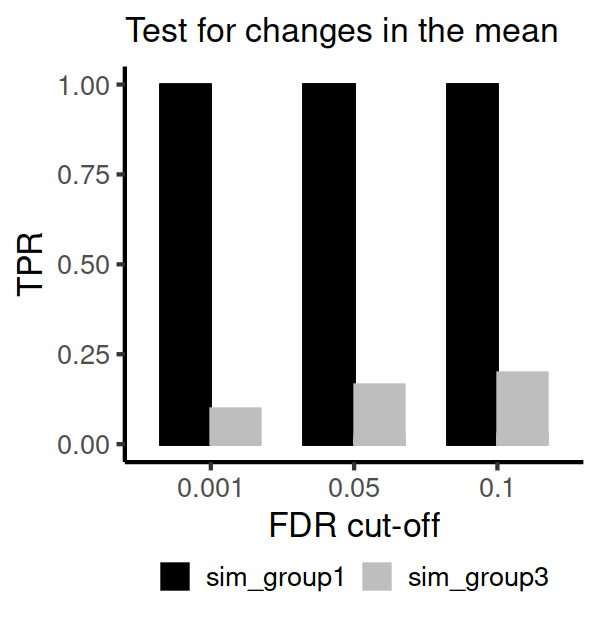

In [42]:
options(repr.plot.width = 5, repr.plot.height = 5.2)
barplot_tpr(plot_mean_res) + 
            labs(subtitle = "Test for changes in the mean")

In [44]:
#combining results for plotting
plot_var_res <- rbind(stats_var[[2]], stats_var[[3]])

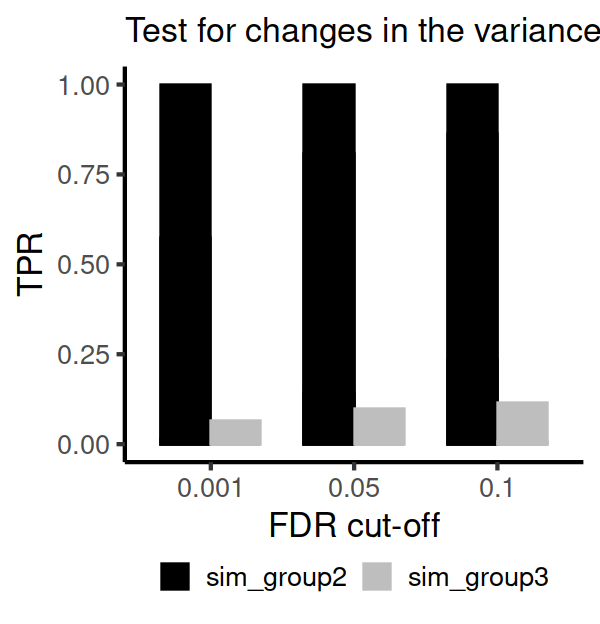

In [45]:
barplot_tpr(plot_var_res) + 
    labs(subtitle = "Test for changes in the variance")

Results in the supplemental figures 3B and 3C show the differential ASE mean or variance analyses between radial glial cells (RGCs) and intermediate progenitors (IPCs) in the female Bl6xCast hybrids. They were obtained by running ASPEN dyn-mean and dyn-var.

### Supplemental Figure 3B

In [46]:
# Loading ASPEN test results
res_dir = "./aspen_output/brain_organoids/Bl6Cast"
diff_ASE_mean <- read.xlsx(paste0(res_dir, "Bl6_Cast_organoids_diffASE_IPCs_vs_RGCs_changemean.xlsx"), rowNames = T)
diff_ASE_var <- read.xlsx(paste0(res_dir, "Bl6_Cast_organoids_diffASE_IPCs_vs_RGCs_changevar.xlsx"), rowNames = T)
# Loading DGE analysis results performed using DESeq2 on the RGCs and IPCs pseudobulked total counts
diff_DGE_res <- read.xlsx(paste0(res_dir, "test_res/Bl6_Cast_organoids_pseudobulk_DGE_IPC_RGC.xlsx"), rowNames = T)


In [47]:
#combining results of dyn-mean and dyn-var tests into one data frame
diff_ASE_res <- diff_ASE_mean
diff_ASE_res$theta_orig_IPCs <- diff_ASE_var$theta_orig_IPCs[match(rownames(diff_ASE_res), rownames(diff_ASE_var))]
diff_ASE_res$theta_orig_RGCs <- diff_ASE_var$theta_orig_RGCs[match(rownames(diff_ASE_res), rownames(diff_ASE_var))]
diff_ASE_res$theta_shrunk_IPCs <- diff_ASE_var$theta_shrunk_IPCs[match(rownames(diff_ASE_res), rownames(diff_ASE_var))]
diff_ASE_res$theta_shrunk_RGCs <- diff_ASE_var$theta_shrunk_RGCs[match(rownames(diff_ASE_res), rownames(diff_ASE_var))]
diff_ASE_res$pval_var <- diff_ASE_var$pval_var[match(rownames(diff_ASE_res), rownames(diff_ASE_var))]
head(diff_ASE_res)

,gene_coord,gene_strand,gene_length,N,AR,tot_gene_mean,tot_gene_variance,alpha,beta,bb_mu,⋯,loglik0,loglik1,llr,pval,fdr_mean,theta_orig_IPCs,theta_orig_RGCs,theta_shrunk_IPCs,theta_shrunk_RGCs,pval_var
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rpl7,chr1:16101295-16104662,-,3368,65,0.5294956,1.2476281,1.9253622,171.549737,157.502798,0.5213,⋯,-1506.1173,-1505.9128,-0.20446279,5.225153e-01,0.7865542394,0.0894,0.0195,0.05446872,0.02564778,1.00000000
Eloc,chr1:16641725-16657042,-,15318,31,0.4928976,0.9530361,1.3309685,7.129368,7.457509,0.4888,⋯,-1180.4116,-1180.4344,0.02281338,1.000000e+00,1.0000000000,0.0754,0.0617,0.05659022,0.04757956,0.06441481
Mcm3,chr1:20802968-20820312,-,17345,23,0.5467542,0.2998102,0.7871476,6.783790,5.224407,0.5649,⋯,-272.0486,-272.3639,0.31528253,1.000000e+00,1.0000000000,0.0507,0.0984,0.10428528,0.10042428,1.00000000
Sdhaf4,chr1:23995939-24005656,-,9718,104,0.4485353,1.4895636,2.4882631,9.410868,11.988252,0.4398,⋯,-1682.1374,-1673.4061,-8.73132391,2.930083e-05,0.0003854575,0.0407,0.0552,0.02852545,0.04051620,1.00000000
Cox5b,chr1:36691449-36693681,+,2233,841,0.5480174,4.5806452,14.2008972,4263.119247,3452.870112,0.5525,⋯,-3168.1941,-3167.7517,-0.44238505,3.468985e-01,0.6257585897,0.0090,0.0001,0.01007104,0.00010000,1.00000000
Pdcl3,chr1:38985608-38997238,+,11631,25,0.5707064,1.0403226,1.3381930,6212.276015,4647.040215,0.5721,⋯,-1224.9401,-1221.5482,-3.39196681,9.198196e-03,0.0523748044,0.0066,0.0001,0.02705110,0.00010000,1.00000000


In [49]:
#removing genes that did not have sufficient expression in either RGCs or IPCs (minimum 5 reads in at least five cells)
diff_ASE_res <- diff_ASE_res[!is.na(diff_ASE_res$mu_groupIPCs),]
diff_ASE_res <- diff_ASE_res[!is.na(diff_ASE_res$mu_groupRGCs),]
diff_ASE_res <- diff_ASE_res[!is.na(diff_ASE_res$pval) & !is.na(diff_ASE_res$pval_var),]
dim(diff_ASE_res)

[1] 743  40

In [50]:
# Adding information about DGE. 
# For those genes, the changes in the allelic variation are likely to be driven 
# by the overall changes in the gene expression and they will be removed from further evaluation
diff_DGE_res_sign <- diff_DGE_res[diff_DGE_res$padj < 0.05,]
diff_ASE_res$diff_DGE <- ifelse(rownames(diff_ASE_res) %in% rownames(diff_DGE_res_sign), 1, 0)
table(diff_ASE_res$diff_DGE)


  0   1 
558 185 

In [51]:
#excluding ribosomal, sex chromosome and imprinted genes
genes.use <- grep(pattern = "^Rp[sl][[:digit:]]|^Rp[[:digit:]]|^Rpsa|^Rplp[[:digit:]]|^Rrpl|^Rp[lp][[:digit:]]|^Gm[[:digit:]]|Rik|-ps|^Rb|^Mrps[[:digit:]]|^Mrpl[[:digit:]]|^Snrp|^Rrs[[:digit:]]|^Zpf[[:digit:]]", 
                  rownames(diff_ASE_res), value=TRUE, invert=TRUE)

genesXY <- read.table("./misc/mm10_genesXY.txt")
genesIMPR <- read.xlsx("./misc/Some_imprinted_genes.xlsx")

diff_ASE_res_filt <- diff_ASE_res[genes.use,]
diff_ASE_res_filt <-  diff_ASE_res_filt[!(rownames(diff_ASE_res_filt) %in% c(genesXY$V1, genesIMPR$imprinted.genes)),]

In [52]:
#excluding DEG genes 
diff_ASE_res_filt <- diff_ASE_res_filt[diff_ASE_res_filt$diff_DGE == 0,]
#recalculating FDR
diff_ASE_res_filt$fdr_mean <- p.adjust(diff_ASE_res_filt$pval, method = "fdr")
diff_ASE_res_filt$fdr_var <-  p.adjust(diff_ASE_res_filt$pval_var, method = "fdr")
diff_ASE_res_filt <- diff_ASE_res_filt[order(diff_ASE_res_filt$fdr_var),]
dim(diff_ASE_res_filt)

[1] 468  42

Calculating overlap between genes with ASE changes driven by either shifts in the allelic ratio mean, variation or both.

In [54]:
#selecting genes with significant allelic imbalance
dynamic_test_res <- list(
  "Changes in mean" = rownames(diff_ASE_res_filt)[diff_ASE_res_filt$fdr_mean < 0.05], 
  "Changes in variance" = rownames(diff_ASE_res_filt)[diff_ASE_res_filt$fdr_var < 0.05]
)

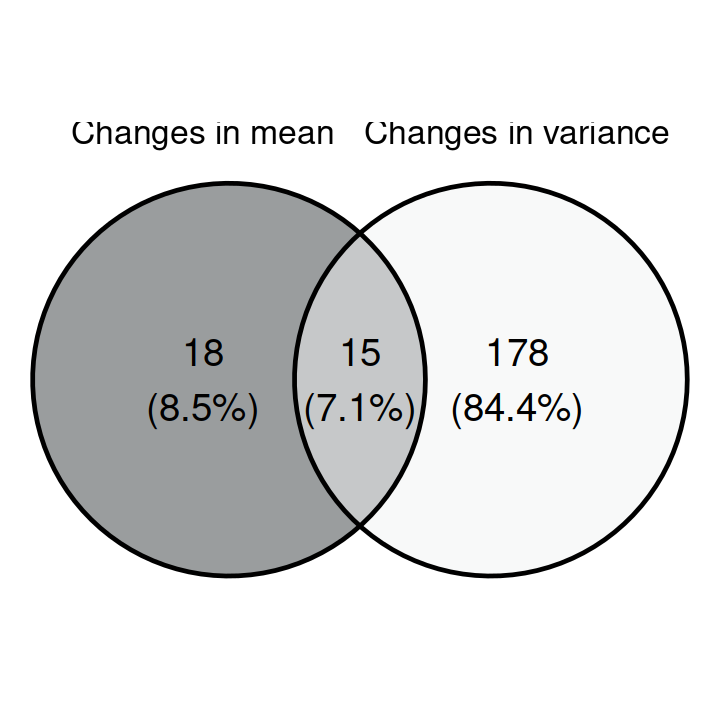

In [58]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggvenn(dynamic_test_res, fill_color = c("#373D3F", "#F2F3F4"),
       text_size = 8, set_name_size = 7)

Heatmaps for the genes with significant changes in allelic variation only

In [60]:
#selecting genes that have significant changes in either mean or variance between RGCs and IPCs
diff_ASE_res_sign <- subset(diff_ASE_res_filt, (fdr_mean < 0.05 | fdr_var < 0.05))
#identifying genes that have significant changes in variance only, without changes in the mean
genes_varAR_only <- rownames(diff_ASE_res_filt)[!(diff_ASE_res_filt$fdr_mean < 0.05) & 
                                                diff_ASE_res_filt$fdr_var < 0.05]

#extracting posterior dispersion estimation
theta_sign_genes <- diff_ASE_res_sign[,c("theta_shrunk_IPCs", "theta_shrunk_RGCs")]
#subsetting posterior dispersion estimates to include genes with changes in variance only
varAR_theta_only_sign_genes <- theta_sign_genes[rownames(theta_sign_genes) %in% genes_varAR_only,]
dim(varAR_theta_only_sign_genes)

[1] 178   2

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


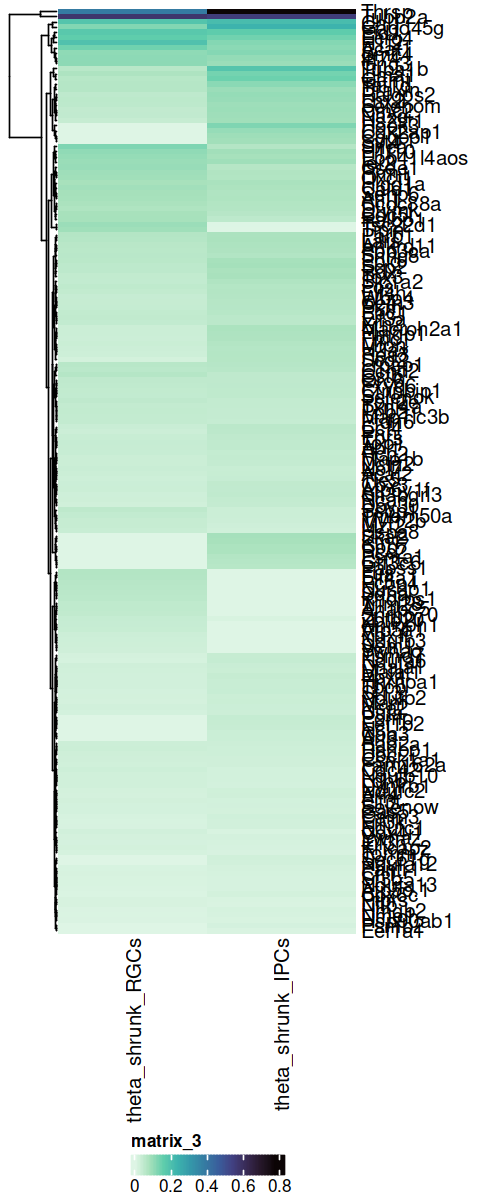

In [64]:
options(repr.plot.width = 4, repr.plot.height = 10)
cont_pal <- viridis_pal(option = "G", direction = -1)(11) 
ht2 <- ComplexHeatmap::Heatmap(varAR_theta_only_sign_genes[,2:1], cluster_rows = TRUE, cluster_columns = FALSE, col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", name = "Allelic Variance"),  
                        row_names_side = "right")
draw(ht2, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

Rows for the allelic ratio heatmap are ordered to match the allelic variance clustering.

In [65]:
#extracting mean allelic ratio values for genes with either significant changes in mean or variance brtween RGCs and IPCs
meanAR_sign_genes <- diff_ASE_res_sign[,c("mu_groupIPCs", "mu_groupRGCs")]
#subsetting to include only genes with significant changes in variance
varAR_only_sign_genes <- meanAR_sign_genes[rownames(meanAR_sign_genes) %in% genes_varAR_only,]

In [66]:
#re-ordering row as per the dispersion heatmap
varAR_only_sign_genes <- varAR_only_sign_genes[row_order(ht2),]  

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


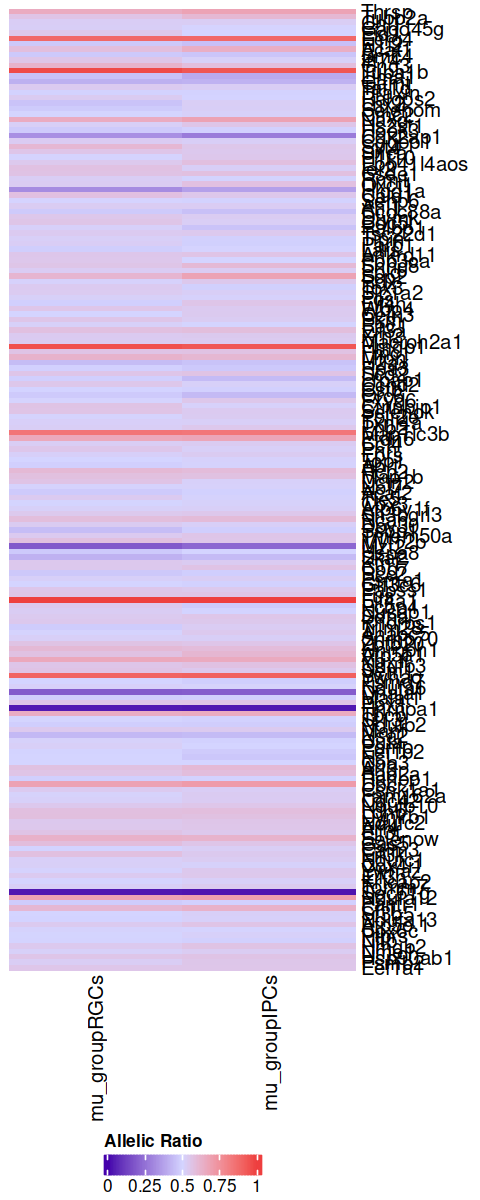

In [67]:
cont_pal <- pal_gsea()(11)
ht2 <- ComplexHeatmap::Heatmap(varAR_only_sign_genes[,2:1], cluster_rows = FALSE, cluster_columns = FALSE, #col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(0, 1, 0.25)), name = "Allelic Ratio",
                        col = circlize::colorRamp2(c(0, 0.5, 1),  cont_pal[c(1,6,11)]), 
                        row_names_side = "right")
draw(ht2, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

Creating heatmaps for genes with changes in both mean and variance

In [68]:
#identifying genes with changes in mean allelic ratio only
genes_meanAR_only <- rownames(diff_ASE_res_filt)[diff_ASE_res_filt$fdr_mean < 0.05 & !(diff_ASE_res_filt$fdr_var < 0.05)]
#selecting genes that have significant changes in both mean and variance
genes_both <- rownames(diff_ASE_res_sign)
#excluding genes that have exclusive changes in either mean or variance
genes_both <- genes_both[!(genes_both %in% c(genes_varAR_only, genes_meanAR_only))]
#subsetting posterior dispersion values to include genes with changes in both mean and variance
theta_both <- theta_sign_genes[rownames(theta_sign_genes) %in% genes_both,]
dim(theta_both)

[1] 15  2

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


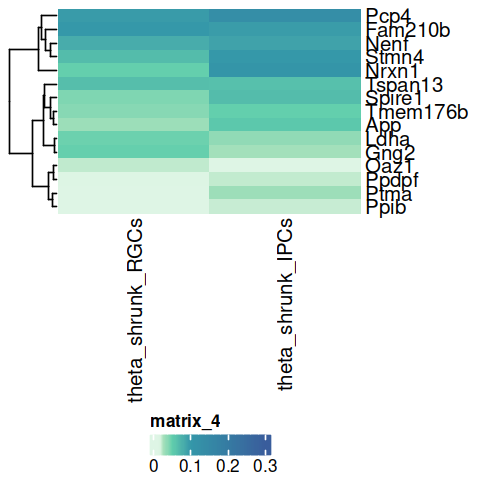

In [69]:
options(repr.plot.width = 4, repr.plot.height = 4)
cont_pal <- viridis_pal(option = "G", direction = -1)(11) 
ht2 <- ComplexHeatmap::Heatmap(theta_both[,2:1], cluster_rows = TRUE, cluster_columns = FALSE, 
                        heatmap_legend_param = list(direction = "horizontal"), 
                        col = circlize::colorRamp2(c(0.015, 0.025, 0.05, 0.1,0.2, 0.3),  cont_pal[c(1,2,3,5,6,7)]),
                        row_names_side = "right")
draw(ht2, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

Re-ordering allelic ratio heatmap by the variance clustering

In [70]:
meanAR_both <- meanAR_sign_genes[rownames(meanAR_sign_genes) %in% genes_both,]
dim(meanAR_both)
meanAR_both <- meanAR_both[row_order(ht2),]  

[1] 15  2

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


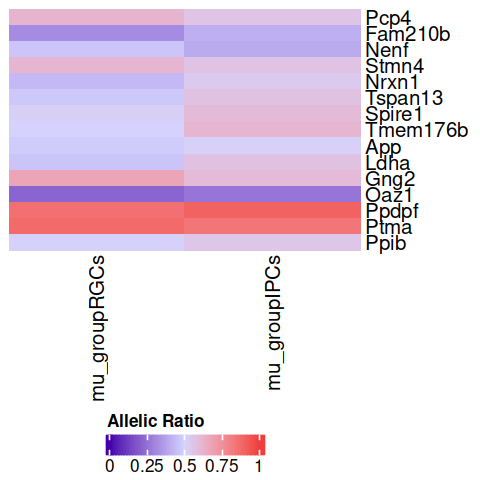

In [71]:
cont_pal <- pal_gsea()(11)
ht2 <- ComplexHeatmap::Heatmap(meanAR_both[,2:1], cluster_rows = FALSE, cluster_columns = FALSE, #col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(0, 1, 0.25)), name = "Allelic Ratio",
                        col = circlize::colorRamp2(c(0, 0.5, 1),  cont_pal[c(1,6,11)]), 
                        row_names_side = "right")
draw(ht2, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

### Supplemental Figure 3C

Some genes with differential ASE changes in either mean or variance were associated with neuroanatomical phenotype changes or Autism Spectrum Disorders. 

Loading SFARI data base genes. Downloaded from https://gene.sfari.org/database/gene-scoring/ (Arpi et al., 2022)

In [72]:
SFARI_genes <- read.csv("./misc/SFARI-genes.csv")
proper=function(x) paste0(toupper(substr(x, 1, 1)), tolower(substring(x, 2)))
SFARI_genes$gene.symbol <- proper(SFARI_genes$gene.symbol)
#selecting genes with SFARI score 1
SFARI_genes <- subset(SFARI_genes, gene.score == 1)
head(SFARI_genes)

,status,gene.symbol,gene.name,ensembl.id,chromosome,genetic.category,gene.score,syndromic,eagle,number.of.reports
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<int>
6,9,Abce1,ATP binding cassette subfamily E member 1,ENSG00000164163,4,Rare Single Gene Mutation,1,0,1.40,3
11,9,Actb,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1,1,1.00,11
22,9,Adnp,Activity-dependent neuroprotector homeobox,ENSG00000101126,20,"Rare Single Gene Mutation, Syndromic, Functional",1,1,41.50,90
24,9,Adsl,adenylosuccinate lyase,ENSG00000239900,22,"Rare Single Gene Mutation, Syndromic",1,1,0.35,9
26,9,Aff2,"AF4/FMR2 family, member 2",ENSG00000155966,X,"Rare Single Gene Mutation, Syndromic",1,0,8.70,22
37,9,Ahdc1,AT-hook DNA binding motif containing 1,ENSG00000126705,1,"Rare Single Gene Mutation, Syndromic",1,1,14.25,30


Loading genes previously found to be associated with neuroanatomical phenotypes (NAPs). List is obtained from Collins, et al., 2019 Nat Comms

In [73]:
NAPgenes <- read.xlsx("./misc/NAP_genes.xlsx")
head(NAPgenes)

,NAP_genes
,<chr>
1,1700024P04Rik
2,1700067K01Rik
3,1700123O20Rik
4,Hpf1
5,4931429L15Rik
6,Abcb6


In [84]:
#reordering data frame with significant results
diff_ASE_res_sign_1 <- diff_ASE_res_sign[diff_ASE_res_sign$fdr_mean < 0.05 & !(diff_ASE_res_sign$fdr_var < 0.05),]
diff_ASE_res_sign_1 <- diff_ASE_res_sign_1[order(diff_ASE_res_sign_1$fdr_var, decreasing = T),]
diff_ASE_res_sign_2 <- diff_ASE_res_sign[diff_ASE_res_sign$fdr_mean < 0.05 & diff_ASE_res_sign$fdr_var < 0.05,]
diff_ASE_res_sign_2 <- diff_ASE_res_sign_2[order(diff_ASE_res_sign_2$fdr_var),]
diff_ASE_res_sign_3 <- diff_ASE_res_sign[!(diff_ASE_res_sign$fdr_mean < 0.05) & diff_ASE_res_sign$fdr_var < 0.05,]
diff_ASE_res_sign_3 <- diff_ASE_res_sign_3[order(diff_ASE_res_sign_3$fdr_var),]
diff_ASE_res_sign_reorder <- rbind(diff_ASE_res_sign_3, diff_ASE_res_sign_1, diff_ASE_res_sign_2)


In [85]:
#adding gene identifiers to the results
diff_ASE_res_sign_reorder$ASD <- ifelse(rownames(diff_ASE_res_sign_reorder) %in% SFARI_genes$gene.symbol, 1, 0)
diff_ASE_res_sign_reorder$NAP <- ifelse(rownames(diff_ASE_res_sign_reorder) %in% NAPgenes$NAP_genes, 1, 0)

In [86]:
#selecting genes implicated in neuroanatomical phenotype changes
diff_ASE_res_sign_reorder_NAP <- diff_ASE_res_sign_reorder[diff_ASE_res_sign_reorder$NAP == 1,]
dim(diff_ASE_res_sign_NAP)

[1]  4 44

In [87]:
mean_df <- diff_ASE_res_sign_reorder_NAP[,c("mu_groupIPCs", "mu_groupRGCs")]
mean_df <- rownames_to_column(mean_df, var = "genes")
mean_df <- melt(mean_df)
mean_df$cell_type <- gsub("mu_group", "", mean_df$variable)
mean_df$cell_type <- factor(mean_df$cell_type, levels = c("RGCs", "IPCs"))
mean_df$value <- round(mean_df$value, 4)
mean_df$genes <- factor(mean_df$genes, levels = rownames(diff_ASE_res_sign_reorder_NAP))
head(mean_df)

Using genes as id variables



,genes,variable,value,cell_type
,<fct>,<fct>,<dbl>,<fct>
1,Lars,mu_groupIPCs,0.5030,IPCs
2,Eif3h,mu_groupIPCs,0.5468,IPCs
3,Selenok,mu_groupIPCs,0.5371,IPCs
4,Oaz1,mu_groupIPCs,0.2588,IPCs
5,Lars,mu_groupRGCs,0.4844,RGCs
6,Eif3h,mu_groupRGCs,0.5370,RGCs


In [81]:
#setting the color scheme
cont_pal <- pal_gsea()(11)

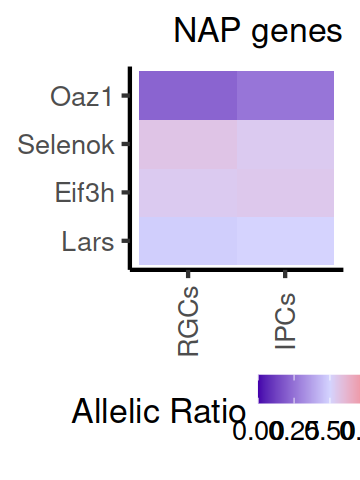

In [88]:
options(repr.plot.width = 3, repr.plot.height = 4)
plot_tiles_ar(mean_df) +
    labs(subtitle = "NAP genes")

In [89]:
var_df <- diff_ASE_res_sign_reorder_NAP[,c("theta_shrunk_IPCs", "theta_shrunk_RGCs")]
var_df <- rownames_to_column(var_df, var = "genes")
var_df <- melt(var_df)
var_df$cell_type <- gsub("theta_shrunk_", "", var_df$variable)
var_df$cell_type <- factor(var_df$cell_type, levels = c("RGCs", "IPCs"))
var_df$value <- round(var_df$value, 4)
var_df$genes <- factor(var_df$genes, levels = rownames(diff_ASE_res_sign_reorder_NAP))
head(var_df)

Using genes as id variables



,genes,variable,value,cell_type
,<fct>,<fct>,<dbl>,<fct>
1,Lars,theta_shrunk_IPCs,0.0734,IPCs
2,Eif3h,theta_shrunk_IPCs,0.0125,IPCs
3,Selenok,theta_shrunk_IPCs,0.0443,IPCs
4,Oaz1,theta_shrunk_IPCs,0.0151,IPCs
5,Lars,theta_shrunk_RGCs,0.0585,RGCs
6,Eif3h,theta_shrunk_RGCs,0.0140,RGCs


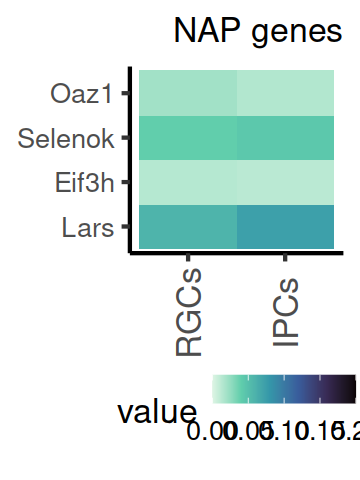

In [94]:
options(repr.plot.width = 3, repr.plot.height = 4)
plot_tiles_var(var_df) +
    labs(subtitle = "NAP genes")

Creating plots for the genes associated with ASD

In [95]:
#subsetting genes associated with ASD
diff_ASE_res_sign_reorder_ASD <- diff_ASE_res_sign_reorder[diff_ASE_res_sign_reorder$ASD == 1,]
dim(diff_ASE_res_sign_reorder_ASD)

[1]  4 44

In [97]:
mean_df <- diff_ASE_res_sign_reorder_ASD[,c("mu_groupIPCs", "mu_groupRGCs")]
mean_df <- rownames_to_column(mean_df, var = "genes")
mean_df <- melt(mean_df)
mean_df$cell_type <- gsub("mu_group", "", mean_df$variable)
mean_df$cell_type <- factor(mean_df$cell_type, levels = c("RGCs", "IPCs"))
mean_df$value <- round(mean_df$value, 4)
mean_df$genes <- factor(mean_df$genes, levels = rownames(diff_ASE_res_sign_reorder_ASD))
head(mean_df)

Using genes as id variables



,genes,variable,value,cell_type
,<fct>,<fct>,<dbl>,<fct>
1,Ankrd11,mu_groupIPCs,0.5609,IPCs
2,Csde1,mu_groupIPCs,0.5767,IPCs
3,Zbtb20,mu_groupIPCs,0.5552,IPCs
4,Nrxn1,mu_groupIPCs,0.5403,IPCs
5,Ankrd11,mu_groupRGCs,0.5516,RGCs
6,Csde1,mu_groupRGCs,0.5661,RGCs


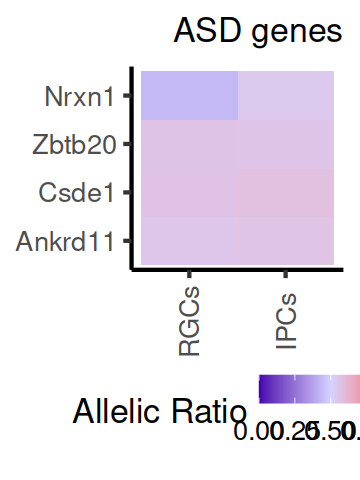

In [98]:
options(repr.plot.width = 3, repr.plot.height = 4)
plot_tiles_ar(mean_df) +
    labs(subtitle = "ASD genes")

In [99]:
var_df <- diff_ASE_res_sign_reorder_ASD[,c("theta_orig_IPCs", "theta_orig_RGCs")]
var_df <- rownames_to_column(var_df, var = "genes")
var_df <- melt(var_df)
var_df$cell_type <- gsub("theta_orig_", "", var_df$variable)
var_df$cell_type <- factor(var_df$cell_type, levels = c("RGCs", "IPCs"))
var_df$value <- round(var_df$value, 4)
var_df$genes <- factor(var_df$genes, levels = rownames(diff_ASE_res_sign_reorder_ASD))
head(var_df)

Using genes as id variables



,genes,variable,value,cell_type
,<fct>,<fct>,<dbl>,<fct>
1,Ankrd11,theta_orig_IPCs,0.0923,IPCs
2,Csde1,theta_orig_IPCs,0.0718,IPCs
3,Zbtb20,theta_orig_IPCs,0.0022,IPCs
4,Nrxn1,theta_orig_IPCs,0.1748,IPCs
5,Ankrd11,theta_orig_RGCs,0.0591,RGCs
6,Csde1,theta_orig_RGCs,0.1735,RGCs


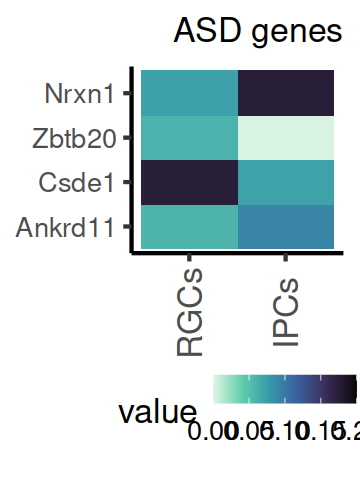

In [100]:
options(repr.plot.width = 3, repr.plot.height = 4)
plot_tiles_var(var_df) +
    labs(subtitle = "ASD genes")